This notebook provides an example for visualizing the sparsity implicit bias of the training with a large learning rate.

In [ ]:
import sys
sys.path.append("..")

In [ ]:
import torch
import torch.nn as nn
from source.utils.utils import load_model
from source.utils.data_funcs import load_data
from source.utils.logger import Logger
from source.utils.train import validate
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

In [ ]:
class config:
    model = 'cifar_vgg16_bn'
    dataset = 'cifar10'
    special_init = 'vgg_init' # 'vgg_init' (kaiming init) or None (uniform init)
    print_freq = 100
    data_dir = '../../Linear_Mode_Connectivity/data'
    n = 3 # number of interpolation points

In [ ]:
# necessary to create logger if using the train/validate/eval_line etc. functions
Logger.setup_logging()
logger = Logger()

trainset, testset = load_data(config.data_dir, config.dataset)
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=256, shuffle=False)

trainset_noaug, _ = load_data(config.data_dir, config.dataset, no_random_aug=True)
trainloader_noaug = DataLoader(trainset_noaug, batch_size=128, shuffle=True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
model_s = []
lr_s = ['0.01', '0.03', '0.05', '0.07', '0.1']

sd_1 = torch.load('../../Linear_Mode_Connectivity/same_init_ex/cifar10/cifar_vgg16_bn/diff_init/seed_10_lr_0.01/model_1_160.pt')
sd_2 = torch.load('../../Linear_Mode_Connectivity/same_init_ex/cifar10/cifar_vgg16_bn/diff_init/seed_10_lr_0.03/model_1_160.pt')
sd_3 = torch.load('../../Linear_Mode_Connectivity/same_init_ex/cifar10/cifar_vgg16_bn/diff_init/seed_10_lr_0.05/model_1_160.pt')
sd_4 = torch.load('../../Linear_Mode_Connectivity/same_init_ex/cifar10/cifar_vgg16_bn/diff_init/seed_10_lr_0.07/model_1_160.pt')
sd_5 = torch.load('../../Linear_Mode_Connectivity/same_init_ex/cifar10/cifar_vgg16_bn/diff_init/seed_10/model_1_160.pt')

for sd in [sd_1, sd_2, sd_3, sd_4, sd_5]:
    model = load_model(config).to(device)
    model.load_state_dict(sd)
    model_s.append(model)

In [ ]:
import torch.nn.utils.prune as prune

res_prune_s = []

for model in model_s:
    res_prune_cur = [[], []]

    for amount in list(np.arange(0, 0.9, 0.1)) + [0.9, 0.95]:
        model_pruned = deepcopy(model)

        parameters_pruned = []
        # resnet
        # for k, v in model_pruned.named_modules():
        #     if 'conv' in k or 'norm' in k or 'fc' in k:
        #         if hasattr(v, 'weight') and v.weight is not None:
        #             parameters_pruned.append((v, 'weight'))
        #         if hasattr(v, 'bias') and v.bias is not None:
        #             parameters_pruned.append((v, 'bias'))
        # vgg_bn
        for k, v in model_pruned.named_modules():
            if isinstance(v, (nn.Conv2d, nn.Linear, nn.BatchNorm2d)):
                if hasattr(v, 'weight') and v.weight is not None:
                    parameters_pruned.append((v, 'weight'))
                if hasattr(v, 'bias') and v.bias is not None:
                    parameters_pruned.append((v, 'bias'))

        parameters_pruned = tuple(parameters_pruned)
        prune.global_unstructured(parameters_pruned, pruning_method=prune.L1Unstructured, amount=amount)

        for param, name in parameters_pruned:
            prune.remove(param, name)

        _, acc, _, _ = validate(trainloader_noaug, model_pruned, criterion, device, config)
        res_prune_cur[0].append(acc)
        _, acc, _, _ = validate(testloader, model_pruned, criterion, device, config)
        res_prune_cur[1].append(acc)
    res_prune_s.append(res_prune_cur)

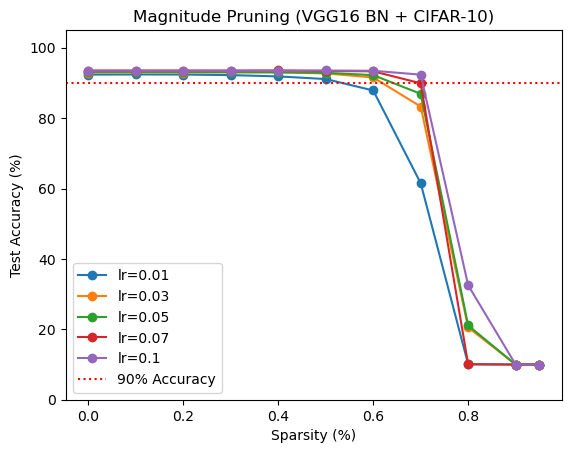

In [13]:
x_axis = list(np.arange(0, 0.9, 0.1)) + [0.9, 0.95]
train = 'test'
idx = 0 if train == 'train' else 1

plt.plot(x_axis, res_prune_s[0][idx], label='lr=0.01', marker='o')
plt.plot(x_axis, res_prune_s[1][idx], label='lr=0.03', marker='o')
plt.plot(x_axis, res_prune_s[2][idx], label='lr=0.05', marker='o')
plt.plot(x_axis, res_prune_s[3][idx], label='lr=0.07', marker='o')
plt.plot(x_axis, res_prune_s[4][idx], label='lr=0.1', marker='o')

# plot a horizontal line at y = 90
plt.axhline(y=90, color='r', linestyle=':', label='90% Accuracy')
plt.xlabel('Sparsity (%)')
if train == 'train':
    plt.ylabel('Training Accuracy (%)')
else:
    plt.ylabel('Test Accuracy (%)')
plt.ylim(0, 105)
plt.title('Magnitude Pruning (VGG16 BN + CIFAR-10)')
plt.legend()